### Example of using CMSSpark for analysis workflow

In [1]:
# IMPORTANT!!!
# ------------
# Before running this notebook please click on star icon (if it is there) to connect to Spark cluster
# it setups spark context variables used in this notebook

In [ ]:
# execute this cell which downloads required libraries and put them in place
import os
with open('env.sh', 'w') as ostream:
    ostream.write("""#!/bin/bash
wdir=$PWD/wdir
if [ -d $wdir ]; then
    rm -rf $wdir
fi
mkdir -p $wdir
cd $wdir
wget https://my.pcloud.com/publink/show?code=XZwzn97ZIoG4isDNO3b6SrTEUfQ1Y4E6bp9k -O ./avro-mapred.jar
wget https://my.pcloud.com/publink/show?code=XZazn97Z9aGq81aVgBLcHi9LBNqryuqs310V -O ./spark-csv-assembly-1.4.0.jar
wget http://cmsdoc.cern.ch/~dciangot/spark-examples.jar -O ./spark-examples-1.6.0-cdh5.7.6-hadoop2.6.0-cdh5.7.6.jar
wget https://github.com/dmwm/CMSSpark/archive/master.zip -O ./master.zip
unzip ./master.zip 2> /dev/null
mv CMSSpark-master CMSSpark""")
!ls
!source ./env.sh
!ls
!cd wdir; ls

analyzer-AOD.ipynb		  pandas_raw
analyzer.ipynb			  panduplizer-Copy1.ipynb
analyzer-MINI.ipynb		  panduplizer.ipynb
cache_emulator.ipynb		  plot.pdf
classAd_file_test.csv.gz	  plots
cmssw_file_test.csv.gz		  spark-dfs
cmssw_reduced_18-1_6.csv	  spark-warehouse
cmssw_reduced_18-19.csv		  wdir
cmssw_reduced_18-7_12.csv	  working_set_classads.ipynb
cmssw_reduced_19-1_5.csv	  ws_17_01.pkl
cmssw_reduced_duration_18-19.csv  ws_17_02.pkl
cmssw_reduced_duration_19.csv	  ws_17_03.pkl
cmssw_reduced_duration.csv	  ws_17_04.pkl
cmssw_reduced_duration_test.csv   ws_17_05.pkl
condor_20180101			  ws_17_06.pkl
dataset_producer.ipynb		  ws_17_07.pkl
dataset_size.pkl.gz		  ws_17_08.pkl
env.sh				  ws_17_09.pkl
hs_err_pid333.log		  ws_17_10.pkl
mkdir.sh			  ws_17_11.pkl
name				  ws_17_12.pkl
pandas_dfs			  xdf_raw_jan_2018.pkl.gz
--2019-06-14 09:19:44--  https://my.pcloud.com/publink/show?code=XZwzn97ZIoG4isDNO3b6SrTEUfQ1Y4E6bp9k
Resolving my.pcloud.com (my.pcloud.com)... 74.120.8.13, 74.120.8.15, 74.1

# ClassAds df creation

In [ ]:
# include the CMSSpark python in the sys.path
import os,sys
sys.path.append(os.path.join(os.path.expanduser("~"), 'SWAN_projects/CMSSpark/src/python'))
#print(sys.path)


In [ ]:
#!ls ws_classAds_csv_mcTrue_19_01/part-*.csv.gz
#print glob.glob(os.path.join('', "ws_classAds_csv_mcTrue_19_%s/part-*.csv.gz"))
!hdfs dfs -ls  hdfs://analytix/cms/users/dciangot

In [3]:
#!hdfs dfs -cp  hdfs://analytix/cms/users/dciangot/ws_classAds_mc*_18_{09,10,11,12} file:${PWD}/spark-dfs/
!hdfs dfs -cp  hdfs://analytix/cms/users/dciangot/01_ws_classAds_mc*_19_{01,02,03,04,05} file:${PWD}/spark-dfs/

cp: `hdfs://analytix/cms/users/dciangot/01_ws_classAds_mc*_19_05': No such file or directory


In [4]:
##working_set_day.head(10)
from pyspark.sql import SQLContext
import subprocess
import pandas as pd

sqlContext = SQLContext(sc)

In [ ]:
block_size = sqlContext.read.parquet("hdfs://analytix/cms/users/dciangot/block_size")

In [ ]:
block_size.columns
block_size.coalesce(1).write.format("com.databricks.spark.csv").save("hdfs://analytix/cms/users/dciangot/block_conversion_2.csv", )
!hdfs dfs -cp  hdfs://analytix/cms/users/dciangot/block_conversion_2.csv file:${PWD}/spark-dfs/

In [ ]:
!hdfs dfs -cp  hdfs://analytix/cms/users/dciangot/block_conversion_2.csv file:${PWD}/spark-dfs/

In [5]:
#mcList = ['False', 'True']
mcList = ['False']
#list = ['18_01', '18_02', '18_03', '18_04', '18_05', '18_06', '18_07', '18_08', '18_09', '18_10', '18_11', '18_12']
#list = ['18_07', '18_08', '18_09', '18_10', '18_11', '18_12']
list = ['19_01', '19_02', '19_03', '19_04']

#!pip install --user -U pyarrow

#import sys
#sys.path.append('/usr/lib/python2.7/site-packages')

for mc in mcList:
    for i in list:
        print mc, i

        import glob, os
        all_files = glob.glob(os.path.join('', "./spark-dfs/01_ws_classAds_mc%s_%s/part-*" % (mc, i)))

        li = []    
        j = 0
        for filename in all_files:
            df = pd.read_parquet(filename)
            li.append(df)

        df = pd.concat(li, axis=0)
        #    print "Saving...", j
        df.to_pickle("./pandas_raw/01_ws_mc%s_%s.pkl" % (mc, i))

    

False 19_01
False 19_02
False 19_03
False 19_04


# CMSSW df creation

In [ ]:
from CMSSpark.spark_utils import condor_tables, cmssw_tables
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [ ]:
tables = {}
tables.update(cmssw_tables(sc, sqlContext, date="year=2018/month=2/day=1", verbose=True))

In [ ]:
tables['cmssw_df'].columns

In [ ]:
#tables['cmssw_df'].groupBy("APP_INFO").count().head(1)

In [ ]:
from pyspark.sql.functions import lit, sum, count, col, split
from pyspark.sql.functions import split, col, first, regexp_extract
import pyspark.sql.functions as fn


df = tables['cmssw_df'].withColumn('DAY', (col('END_TIME')-col('END_TIME')%fn.lit(86400)))\
                       .groupBy(["DAY" ,"APP_INFO", "USER_DN", "SITE_NAME", "CLIENT_DOMAIN", "SERVER_DOMAIN", "FILE_LFN"])\
                       .agg( sum("READ_BYTES_AT_CLOSE").alias("READ_BYTES"),
                             (sum("END_TIME") - sum("START_TIME")).alias('DURATION') )

In [ ]:
df.columns

In [ ]:
#df.head(50)

In [ ]:
#from pyspark.sql.functions import split, col, first, regexp_extract


df_new = df.filter(regexp_extract('APP_INFO', r'(crab)', 1)!='')\
       .withColumn('CRAB_TASK', regexp_extract('APP_INFO', r'(.*)$',1))\
       .withColumn('USER', regexp_extract('APP_INFO', r'.*/\d{6}:\d{6}:(\w+):.*',1))\
       .withColumn('JOB_ID', regexp_extract('APP_INFO', r'.*/\d{6}:\d{6}.*-(\w+_\d+)$',1))\
       .withColumn('DATA_TYPE', regexp_extract('FILE_LFN', r'/\w+/(\w+)/.*', 1))\
       .withColumn('DATA_CAMPAIGN', regexp_extract('FILE_LFN', r'/\w+/\w+/(\w+)/.*', 1))\
       .withColumn('DATA_PROCESS', regexp_extract('FILE_LFN', r'/\w+/\w+/\w+/(\w+)/.*', 1))\
       .withColumn('DATA_TIER', regexp_extract('FILE_LFN', r'/\w+/\w+/\w+/\w+/(\w+)/.*', 1))\
       .withColumn('DATASET', regexp_extract('FILE_LFN', r'/(.*)/\d+{5}/.*.root$', 1))\
       .drop('APP_INFO').drop('USER_DN')

#TODO: sum size

#print df['data_type'].head(5)
#print df['data_campaign'].head(5)

In [ ]:
df_new.columns

In [ ]:
print df_new.groupBy("DAY").agg(sum('DURATION')).head(5)

In [ ]:
df_new.coalesce(1).write.format("com.databricks.spark.csv").save("hdfs://analytix/cms/users/dciangot/cmssw_test_duration.csv" )
#df_new.drop_duplicates(subset=['FILE_LFN']).groupBy('DAY').agg(sum('READ_BYTES')).head(2)

In [ ]:
!hdfs dfs -ls hdfs://analytix/cms/users/dciangot/cmssw_test_duration.csv

In [ ]:
df_reduced = df_new.groupBy([
 'DAY',
 'SITE_NAME',
 'CLIENT_DOMAIN',
 'SERVER_DOMAIN',
 'CRAB_TASK',
 'USER',
 'JOB_ID',
 'DATA_TYPE',
 'DATA_CAMPAIGN',
 'DATA_PROCESS',
 'DATA_TIER']).agg(sum("READ_BYTES").alias("SUM_BYTES_READ"), sum("DURATION").alias("SUM_DURATION"))

!hdfs dfs -rm hdfs://analytix/cms/users/dciangot/cmssw_reduced_duration.csv
df_reduced.coalesce(1).write.format("com.databricks.spark.csv").save("hdfs://analytix/cms/users/dciangot/cmssw_reduced_duration.csv" )

In [ ]:
!hdfs dfs -ls hdfs://analytix/cms/users/dciangot/
#!rm ${PWD}/cmssw_reduced_duration.csv
#!hdfs dfs -cp hdfs://analytix/cms/users/dciangot/cmssw_reduced_duration.csv/part-00000-f1283229-515b-4ac5-a4dd-2910d7abfb85-c000.csv file:${PWD}/cmssw_reduced_duration.csv

# PANDAS xchecks

In [29]:
!rm ${PWD}/cmssw_reduced_duration_18-1_6.csv.gz
!rm ${PWD}/cmssw_reduced_duration_18-7_12.csv.gz
#!rm ${PWD}/cmssw_reduced_duration_19-1_5.csv.gz

!hdfs dfs -cp hdfs://analytix/cms/users/dciangot/cmssw_reduced_18-1_6/part-*.csv file:${PWD}/cmssw_reduced_18-1_6.csv.gz
!hdfs dfs -cp hdfs://analytix/cms/users/dciangot/cmssw_reduced_18-7_12/part-*.csv file:${PWD}/cmssw_reduced_18-7_12.csv.gz
#!hdfs dfs -cp hdfs://analytix/cms/users/dciangot/cmssw_reduced_19-1_5/part-*.csv file:${PWD}/cmssw_reduced_19-1_5.csv.gz

#!rm ${PWD}/cmssw_reduced_duration_test.csv.gz
#!hdfs dfs -cp hdfs://analytix/cms/users/dciangot/cmssw_reduced_test/part-*.csv file:${PWD}/cmssw_reduced_duration_test.csv.gz

!zcat ${PWD}/cmssw_reduced_18-1_6.csv.gz > cmssw_reduced_18-19.csv
!zcat ${PWD}/cmssw_reduced_18-7_12.csv.gz >>  cmssw_reduced_18-19.csv
!zcat ${PWD}/cmssw_reduced_19-1_5.csv.gz >>  cmssw_reduced_18-19.csv

In [49]:
#!rm ${PWD}/cmssw_file_test.csv.gz
#!hdfs dfs -cp hdfs://analytix/cms/users/dciangot/cmssw_file_test-1/part-*.csv* file:${PWD}/cmssw_file_test.csv.gz
        
!rm ${PWD}/classAd_file_test.csv.gz
!hdfs dfs -cp hdfs://analytix/cms/users/dciangot/01_ws_classAds_mcFalse_test/part-*.csv* file:${PWD}/classAd_file_test.csv.gz

rm: cannot remove ‘/eos/home-d/dciangot/SWAN_projects/CMSSpark/src/notebooks/classAd_file_test.csv.gz’: No such file or directory


In [1]:
#!hdfs dfs -cp hdfs://analytix/cms/users/dciangot/cmssw_reduced_19/part-00000-0d68bcbd-946c-4ff8-a8fe-072de65fec48-c000.csv file:${PWD}/cmssw_reduced_duration_19.csv
import pandas as pd

#pd_reduced = pd.read_csv('./cmssw_reduced_18-19.csv', names=[
pd_reduced = pd.read_csv('./cmssw_file_test.csv.gz', names=[
 'DAY',
 'FALLBACK',
 'SITE_NAME',
 'CLIENT_DOMAIN',
 'SERVER_DOMAIN',
 'CRAB_TASK',
 'USER',
 'JOBID',
 'DATA_TYPE',
 'DATA_CAMPAIGN',
 'DATA_PROCESS',
 'DATA_TIER',
 'DATASET',
 'SUM_BYTES_READ',
 'SUM_DURATION',
 'SUM_FILES'])#.fillna("Unknown")

pd_class_reduced = pd.read_csv('./classAd_file_test.csv.gz', names=[
    'day', 'CRAB_Id', 'DESIRED_CMSDataset', 'CRAB_DataBlock',
    'Country', 'RequestCpus', 'Type', 'CMSSite', 'CRAB_Workflow',
    'CRAB_UserHN', 'OVERFLOW_CHECK', 'InputData', 'd_data_tier_id',
    'block_size', 'dataset_size', 'OverflowType', 'Chirp_CRAB3_Job_ExitCode',
    'WallClock',
    'CPUTime',
    'CoreTime'])

In [2]:
#len(pd_reduced) - pd_reduced.CRAB_TASK.count()
print pd_reduced.count()
pd_reduced = pd_reduced.fillna("USER")

print pd_class_reduced.count()
pd_class_reduced = pd_class_reduced.dropna(subset=['CRAB_Id'])

DAY               268150
FALLBACK          268150
SITE_NAME         268150
CLIENT_DOMAIN     268150
SERVER_DOMAIN     268150
CRAB_TASK         268150
USER              268150
JOBID             268150
DATA_TYPE         266717
DATA_CAMPAIGN     266717
DATA_PROCESS      266717
DATA_TIER         256561
DATASET           263705
SUM_BYTES_READ    268150
SUM_DURATION      268150
SUM_FILES         268150
dtype: int64
day                         260946
CRAB_Id                     254850
DESIRED_CMSDataset          260946
CRAB_DataBlock              260946
Country                     260946
RequestCpus                 260946
Type                        260946
CMSSite                     254850
CRAB_Workflow               260946
CRAB_UserHN                 260946
OVERFLOW_CHECK              254850
InputData                   259804
d_data_tier_id              260946
block_size                  260946
dataset_size                260946
OverflowType                 84973
Chirp_CRAB3_Job_ExitCode   

In [3]:
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import datetime

import numpy as np
import os
from pandas.plotting import table
import re

pd_reduced['day'] = pd.to_datetime(pd_reduced['DAY'],unit='s')
pd_class_reduced['day'] = pd.to_datetime(pd_class_reduced['day'],unit='s')
# CRAB_TASK replace _ , :

pd_reduced['TASK'] = pd_reduced.CRAB_TASK.apply(lambda x: x.split("_")[0])

#pd_reduced.drop('CRAB_TASK')

pd_class_reduced['TASK'] = pd_class_reduced.CRAB_Workflow.apply(lambda x: x.replace("_",":"))

#pd_class_reduced.drop('CRAB_Workflow')

pd_class_reduced['JOBID'] = pd_class_reduced.CRAB_Id.apply(lambda x: str(x))
pd_reduced['JOBID'] = pd_reduced.JOBID.apply(lambda x: str(x))

In [4]:
pd_class_reduced.head(10)

,day,CRAB_Id,DESIRED_CMSDataset,CRAB_DataBlock,Country,RequestCpus,Type,CMSSite,CRAB_Workflow,CRAB_UserHN,...,d_data_tier_id,block_size,dataset_size,OverflowType,Chirp_CRAB3_Job_ExitCode,WallClock,CPUTime,CoreTime,TASK,JOBID
0,2018-10-01,42,/JetHT/Run2017E-31Mar2018-v1/NANOAOD,/JetHT/Run2017E-31Mar2018-v1/NANOAOD#da88c0ed-...,US,1,analysis,T2_US_MIT,180930_152512:kkallone_crab_JetHTRun2017E,kkallone,...,2056891,153280000.0,6.151499e+11,FrontendOverflow,0.0,11.265278,2.027500,11.265278,180930:152512:kkallone:crab:JetHTRun2017E,42
1,2018-10-01,28,/JetHT/Run2017E-31Mar2018-v1/NANOAOD,/JetHT/Run2017E-31Mar2018-v1/NANOAOD#da88c0ed-...,US,1,analysis,T2_US_MIT,180930_152512:kkallone_crab_JetHTRun2017E,kkallone,...,2056891,153280000.0,6.151499e+11,FrontendOverflow,0.0,11.229444,2.406944,11.229444,180930:152512:kkallone:crab:JetHTRun2017E,28
2,2018-10-01,5,/JetHT/Run2017E-31Mar2018-v1/NANOAOD,/JetHT/Run2017E-31Mar2018-v1/NANOAOD#da88c0ed-...,US,1,analysis,T2_US_Vanderbilt,180930_152512:kkallone_crab_JetHTRun2017E,kkallone,...,2056891,153280000.0,6.151499e+11,FrontendOverflow,0.0,12.528056,2.243889,12.528056,180930:152512:kkallone:crab:JetHTRun2017E,5
3,2018-10-01,27,/JetHT/Run2017E-31Mar2018-v1/NANOAOD,/JetHT/Run2017E-31Mar2018-v1/NANOAOD#da88c0ed-...,US,1,analysis,T2_US_MIT,180930_152512:kkallone_crab_JetHTRun2017E,kkallone,...,2056891,153280000.0,6.151499e+11,FrontendOverflow,0.0,12.862778,3.568889,12.862778,180930:152512:kkallone:crab:JetHTRun2017E,27
4,2018-10-01,8,/JetHT/Run2017E-31Mar2018-v1/NANOAOD,/JetHT/Run2017E-31Mar2018-v1/NANOAOD#da88c0ed-...,US,1,analysis,T2_US_MIT,180930_152512:kkallone_crab_JetHTRun2017E,kkallone,...,2056891,153280000.0,6.151499e+11,FrontendOverflow,0.0,15.317778,3.162222,15.317778,180930:152512:kkallone:crab:JetHTRun2017E,8
5,2018-10-01,39,/JetHT/Run2017E-31Mar2018-v1/NANOAOD,/JetHT/Run2017E-31Mar2018-v1/NANOAOD#da88c0ed-...,US,1,analysis,T2_US_Vanderbilt,180930_152512:kkallone_crab_JetHTRun2017E,kkallone,...,2056891,153280000.0,6.151499e+11,FrontendOverflow,0.0,30.045556,5.515000,30.045556,180930:152512:kkallone:crab:JetHTRun2017E,39
6,2018-10-01,37,/JetHT/Run2017E-31Mar2018-v1/NANOAOD,/JetHT/Run2017E-31Mar2018-v1/NANOAOD#da88c0ed-...,US,1,analysis,T2_US_Nebraska,180930_152512:kkallone_crab_JetHTRun2017E,kkallone,...,2056891,153280000.0,6.151499e+11,FrontendOverflow,0.0,14.344722,2.973611,14.344722,180930:152512:kkallone:crab:JetHTRun2017E,37
7,2018-10-01,32,/JetHT/Run2017E-31Mar2018-v1/NANOAOD,/JetHT/Run2017E-31Mar2018-v1/NANOAOD#da88c0ed-...,US,1,analysis,T2_US_MIT,180930_152512:kkallone_crab_JetHTRun2017E,kkallone,...,2056891,153280000.0,6.151499e+11,FrontendOverflow,0.0,10.954444,3.072500,10.954444,180930:152512:kkallone:crab:JetHTRun2017E,32
8,2018-10-01,35,/JetHT/Run2017E-31Mar2018-v1/NANOAOD,/JetHT/Run2017E-31Mar2018-v1/NANOAOD#da88c0ed-...,US,1,analysis,T2_US_Wisconsin,180930_152512:kkallone_crab_JetHTRun2017E,kkallone,...,2056891,153280000.0,6.151499e+11,FrontendOverflow,0.0,16.571944,4.411389,16.571944,180930:152512:kkallone:crab:JetHTRun2017E,35
9,2018-10-01,14,/JetHT/Run2017E-31Mar2018-v1/NANOAOD,/JetHT/Run2017E-31Mar2018-v1/NANOAOD#da88c0ed-...,US,1,analysis,T2_US_UCSD,180930_152512:kkallone_crab_JetHTRun2017E,kkallone,...,2056891,153280000.0,6.151499e+11,FrontendOverflow,0.0,16.612778,2.024444,16.612778,180930:152512:kkallone:crab:JetHTRun2017E,14


In [5]:
pd_reduced.head(10)

,DAY,FALLBACK,SITE_NAME,CLIENT_DOMAIN,SERVER_DOMAIN,CRAB_TASK,USER,JOBID,DATA_TYPE,DATA_CAMPAIGN,DATA_PROCESS,DATA_TIER,DATASET,SUM_BYTES_READ,SUM_DURATION,SUM_FILES,day,TASK
0,1.538352e+09,-,T2_US_Caltech,tier2,ultralight.org,180930:230034:jlidrych:crab:MC-QCD:Pt600to800_0,jlidrych,285,mc,RunIIFall17MiniAODv2,QCD_Pt_600to800_TuneCP5_13TeV_pythia8,MINIAODSIM,store/mc/RunIIFall17MiniAODv2/QCD_Pt_600to800_...,3.942161e+09,1673.0,6.326584e+09,2018-10-01,180930:230034:jlidrych:crab:MC-QCD:Pt600to800
1,1.538352e+09,1,T2_US_Vanderbilt,vampire,unknown,180930:124329:prabhat:crab:PbPb2015:pixelReRec...,prabhat,485,hidata,HIRun2015,HIMinimumBias2,AOD,store/hidata/HIRun2015/HIMinimumBias2/AOD/25Au...,2.170241e+10,6308.0,1.162040e+11,2018-10-01,180930:124329:prabhat:crab:PbPb2015:pixelReRec...
2,1.538352e+09,-,T1_FR_CCIN2P3,unknown,in2p3.fr,180930:202751:schenara:crab:20180930:222711_0,schenara,1093,data,Run2018A,SingleMuon,RAW-RECO,store/data/Run2018A/SingleMuon/RAW-RECO/ZMu-Pr...,2.706295e+08,121.0,3.780151e+09,2018-10-01,180930:202751:schenara:crab:20180930:222711
3,1.538352e+09,-,T2_CH_CERN,cern.ch,cern.ch,181001:074610:sciaba:crab:HC-102-T2:CH:CERN-66...,sciaba,90,mc,HC,GenericTTbar,AODSIM,store/mc/HC/GenericTTbar/AODSIM/CMSSW_9_2_6_91...,5.973062e+08,1719.0,2.410048e+09,2018-10-01,181001:074610:sciaba:crab:HC-102-T2:CH:CERN-66...
4,1.538352e+09,-,T2_IT_Pisa,pi.infn.it,unknown,181001:091645:battilan:crab:DTTree:Prompt:ZMuS...,battilan,749,data,Run2018D,SingleMuon,RAW-RECO,store/data/Run2018D/SingleMuon/RAW-RECO/ZMu-Pr...,4.172255e+09,247.0,2.071632e+10,2018-10-01,181001:091645:battilan:crab:DTTree:Prompt:ZMuS...
5,1.538352e+09,-,T2_US_Florida,ufhpc,unknown,181001:084538:santocch:crab:dy-m50_0,santocch,986,mc,RunIIFall17DRPremix,DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pyt...,AODSIM,store/mc/RunIIFall17DRPremix/DYJetsToLL_M-50_T...,3.525910e+09,1505.0,6.868311e+09,2018-10-01,181001:084538:santocch:crab:dy-m50
6,1.538352e+09,-,T2_US_Purdue,unknown,unknown,181001:121634:mpieters:crab:Run2015D:jets:lowP...,mpieters,394,data,Run2015D,L1MinimumBiasHF3,MINIAOD,store/data/Run2015D/L1MinimumBiasHF3/MINIAOD/1...,4.464088e+07,37.0,9.683907e+07,2018-10-01,181001:121634:mpieters:crab:Run2015D:jets:lowP...
7,1.538352e+09,-,T1_RU_JINR,jinr-t1.ru,unknown,181001:095126:gkaratha:crab:20181001:115115_0,gkaratha,109,data,Run2018B,ParkingBPH2,AOD,store/data/Run2018B/ParkingBPH2/AOD/PromptReco...,2.485029e+10,20245.0,5.722678e+10,2018-10-01,181001:095126:gkaratha:crab:20181001:115115
8,1.538352e+09,-,T2_CH_CERN,cern.ch,cern.ch,181001:151520:nvoytish:crab:ZMu:2017F:v1:RUOrig_0,nvoytish,100,data,Run2017F,SingleMuon,RAW-RECO,store/data/Run2017F/SingleMuon/RAW-RECO/ZMu-17...,2.983271e+10,2393.0,1.320240e+11,2018-10-01,181001:151520:nvoytish:crab:ZMu:2017F:v1:RUOrig
9,1.538352e+09,-,T1_ES_PIC,pic.es,unknown,181001:143629:sciaba:crab:HC-102-T1:ES:PIC-662...,sciaba,136,mc,HC,GenericTTbar,AODSIM,store/mc/HC/GenericTTbar/AODSIM/CMSSW_9_2_6_91...,6.483172e+08,1436.0,5.610921e+06,2018-10-01,181001:143629:sciaba:crab:HC-102-T1:ES:PIC-662...


In [17]:
result = pd.merge(pd_reduced, pd_class_reduced, on=['day','TASK','JOBID'])

result.columns

Index([u'DAY', u'FALLBACK', u'SITE_NAME', u'CLIENT_DOMAIN', u'SERVER_DOMAIN',
       u'CRAB_TASK', u'USER', u'JOBID', u'DATA_TYPE', u'DATA_CAMPAIGN',
       u'DATA_PROCESS', u'DATA_TIER', u'DATASET', u'SUM_BYTES_READ',
       u'SUM_DURATION', u'SUM_FILES', u'day', u'TASK', u'CRAB_Id',
       u'DESIRED_CMSDataset', u'CRAB_DataBlock', u'Country', u'RequestCpus',
       u'Type', u'CMSSite', u'CRAB_Workflow', u'CRAB_UserHN',
       u'OVERFLOW_CHECK', u'InputData', u'd_data_tier_id', u'block_size',
       u'dataset_size', u'OverflowType', u'Chirp_CRAB3_Job_ExitCode',
       u'WallClock', u'CPUTime', u'CoreTime'],
      dtype='object')

In [14]:
result.count()

DAY                         273594
FALLBACK                    273594
SITE_NAME                   273594
CLIENT_DOMAIN               273594
SERVER_DOMAIN               273594
CRAB_TASK                   273594
USER                        273594
JOBID                       273594
DATA_TYPE                   273594
DATA_CAMPAIGN               273594
DATA_PROCESS                273594
DATA_TIER                   273594
DATASET                     273594
SUM_BYTES_READ              273594
SUM_DURATION                273594
SUM_FILES                   273594
day                         273594
TASK                        273594
CRAB_Id                     273594
DESIRED_CMSDataset          273594
CRAB_DataBlock              273594
Country                     273594
RequestCpus                 273594
Type                        273594
CMSSite                     273594
CRAB_Workflow               273594
CRAB_UserHN                 273594
OVERFLOW_CHECK              273594
InputData           

In [40]:
#len(pd_reduced)

#print pd_reduced[pd_reduced["DATA_TIER"]=="Unknown"].DATA_TYPE.head(2).values
#print pd_reduced[pd_reduced["DATA_TIER"]=="Unknown"].DATA_CAMPAIGN.head(2).values
#print pd_reduced[pd_reduced["DATA_TIER"]=="Unknown"].DATA_PROCESS.head(2).values
#print pd_reduced[pd_reduced["DATA_TIER"]=="USER"].DATASET.head(2).values
#for i in pd_reduced.SUM_FILES.values:
#    print i
#    print int(i)

pd_reduced.head(10)
#pd_reduced['fsize'] = pd_reduced.SUM_FILES.apply(lambda x: int(x) if x != 'USER' else 0)
#pd_reduced['bsize'] = pd_reduced.block_size.apply(lambda x: int(x) if x != 'USER' else 0)

,DAY,FALLBACK,SITE_NAME,CLIENT_DOMAIN,SERVER_DOMAIN,CRAB_TASK,USER,DATA_TYPE,DATA_CAMPAIGN,DATA_PROCESS,DATA_TIER,DATASET,SUM_BYTES_READ,SUM_DURATION,SUM_FILES
0,1.539216e+09,-,T2_DE_DESY,desy.de,unknown,181011:145422:bko:crab:run2:2016v5:JetHT:Run20...,bko,data,Run2016C,JetHT,MINIAOD,store/data/Run2016C/JetHT/MINIAOD/07Aug17-v1,7.947591e+11,2799104.0,1.817938e+09
1,1.539216e+09,1,T2_US_UCSD,t2.ucsd.edu,fnal.gov,181011:133754:charaf:crab:fromLHE:charaf-HToZd...,charaf,user,charaf,fromLHE,USER,store/user/charaf/fromLHE/HToZdZdTo4L_MZd20_20...,3.345725e+09,6448.0,3.534647e+09
2,1.540944e+09,1,T2_US_Wisconsin,hep.wisc.edu,rcac.purdue.edu,181031:111953:gpaspala:crab:SingleMuon:Run2016...,gpaspala,data,Run2016G,SingleMuon,MINIAOD,store/data/Run2016G/SingleMuon/MINIAOD/23Sep20...,1.171512e+11,69981.0,1.372619e+11
3,1.540944e+09,-,T2_US_Florida,ufhpc,unknown,181031:125639:dvats:crab:SingleElectron:2018D_0,dvats,data,Run2018D,EGamma,MINIAOD,store/data/Run2018D/EGamma/MINIAOD/PromptReco-...,1.955512e+10,10227.0,8.563324e+10
4,1.540944e+09,-,T2_US_Purdue,unknown,unknown,181031:130738:dvats:crab:SingleMuon:2018D_0,dvats,data,Run2018D,SingleMuon,MINIAOD,store/data/Run2018D/SingleMuon/MINIAOD/PromptR...,3.362452e+10,12485.0,9.185002e+10
5,1.540944e+09,1,T2_US_UCSD,t2.ucsd.edu,hep.wisc.edu,181031:153850:pvolkov:crab:ttbar_1,pvolkov,mc,RunIIFall17MiniAODv2,TTToSemiLeptonic_TuneCP5_PSweights_13TeV-powhe...,MINIAODSIM,store/mc/RunIIFall17MiniAODv2/TTToSemiLeptonic...,2.790083e+08,3903.0,4.291342e+10
6,1.540944e+09,-,T2_PT_NCG_Lisbon,ncg.ingrid.pt,cern.ch,181031:100433:adiflori:crab:GEN-MINIAODSIM:BBb...,adiflori,USER,USER,USER,USER,USER,4.001022e+10,17600.0,1.109404e+11
7,1.540944e+09,-,T2_CH_CERN,cern.ch,cern.ch,181031:151801:byates:crab:d0mu_0,byates,mc,RunIISummer16MiniAODv2,TT_TuneCUETP8M2T4_13TeV-powheg-pythia8,MINIAODSIM,store/mc/RunIISummer16MiniAODv2/TT_TuneCUETP8M...,1.224610e+11,4762070.0,2.362774e+12
8,1.540944e+09,-,T2_US_Nebraska,0-red-c1513.unl.edu,cern.ch,181031:100626:adiflori:crab:GEN-MINIAODSIM:BBb...,adiflori,USER,USER,USER,USER,USER,2.255784e+09,1954.0,8.449247e+09
9,1.540944e+09,-,T1_UK_RAL,0-lcg2230.gridpp.rl.ac.uk,echo.stfc.ac.uk,181031:174144:gpaspala:crab:JetHT:Run2016B-03F...,gpaspala,data,Run2016B,JetHT,MINIAOD,store/data/Run2016B/JetHT/MINIAOD/03Feb2017_ve...,8.359822e+10,16808.0,7.236365e+10


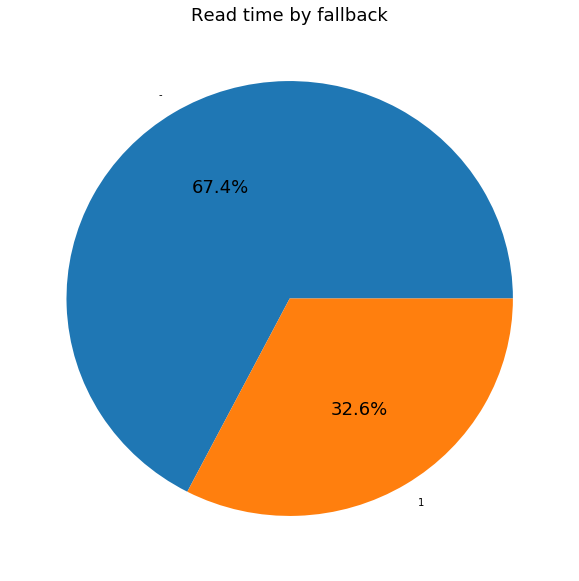

In [42]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

plot_df = pd_reduced.groupby("FALLBACK").SUM_DURATION.sum()
wedges, texts, autotexts = ax.pie(plot_df.values, labels=plot_df.index, autopct='%1.1f%%', textprops={"fontsize":18})

#print pd_reduced.groupby(["DATA_TIER"]).SUM_BYTES_READ.sum().sort_values()

ax.set_title('Read time by fallback', fontdict={"fontsize":18})
ax.set_ylabel("", fontdict={"fontsize":18})


plt.show()

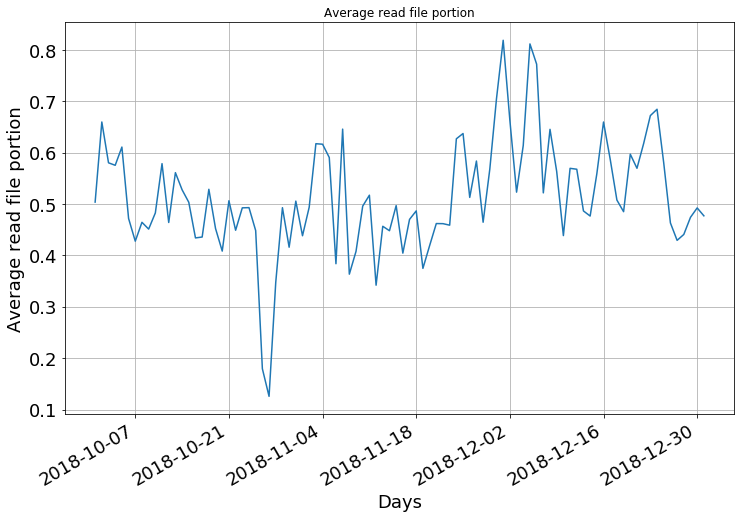

In [43]:
ax = (pd_reduced.groupby('day').SUM_BYTES_READ.sum()/pd_reduced.groupby('day').SUM_FILES.sum()).plot(title="Average read file portion" ,figsize=(12, 8), fontsize=18, x_compat=True)

ax.grid(True)


ax.tick_params(labelsize=18)

#ax.set_ylim(0,400000000)

ax.set_xlabel("Days", fontdict={"fontsize":18})
ax.set_ylabel("Average read file portion", fontdict={"fontsize":18})

plt.show()

In [44]:
#print pd_reduced.groupby(['day','block_size']).SUM_FILES.sum().reset_index().drop_duplicates(subset=['block_size']).groupby('day').block_size.sum()

#ax = (pd_reduced.drop_duplicates(subset=['block_size']).groupby('day').block_size.sum()).plot(title="Average read file portion" ,figsize=(12, 8), fontsize=18, x_compat=True)

#ax.grid(True)


#ax.tick_params(labelsize=18)

#ax.set_ylim(0,400000000)

#ax.set_xlabel("Days", fontdict={"fontsize":18})
#ax.set_ylabel("Average read file portion", fontdict={"fontsize":18})

#plt.show()

KeyError: 'block_size'

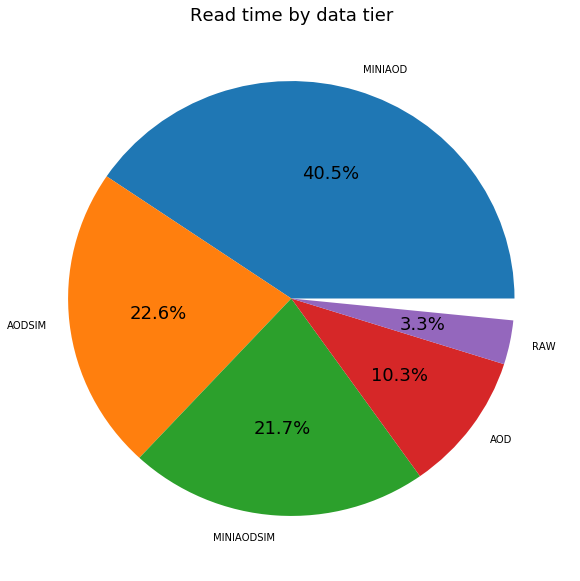

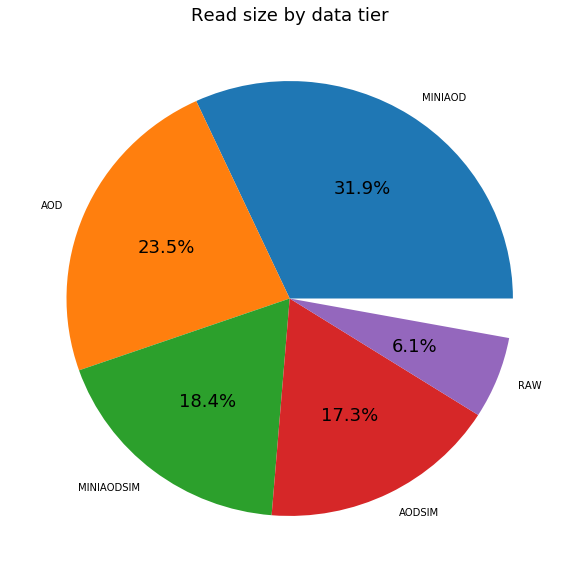

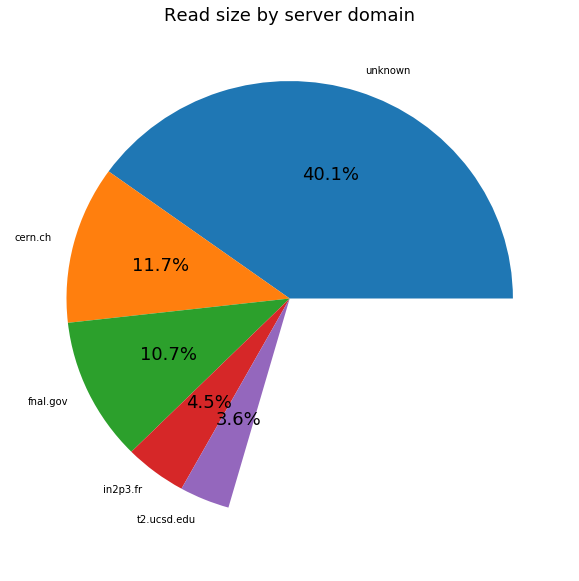

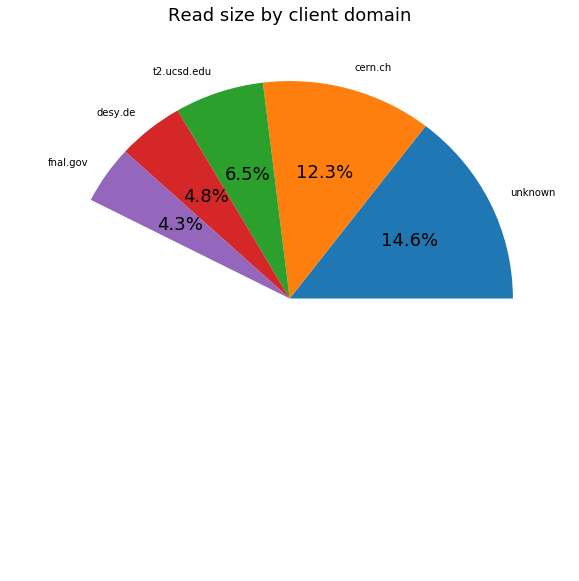

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

plot_df = pd_reduced.groupby(["DATA_TIER"]).SUM_DURATION.sum().sort_values().nlargest(5)/pd_reduced.SUM_DURATION.sum()

wedges, texts, autotexts = ax.pie(plot_df.values, labels=plot_df.index, autopct='%1.1f%%', textprops={"fontsize":18})

#print pd_reduced.groupby(["DATA_TIER"]).SUM_DURATION.sum().sort_values()

ax.set_title('Read time by data tier', fontdict={"fontsize":18})
ax.set_ylabel("", fontdict={"fontsize":18})

#print "CPU equivalent 0:", plot_series[0]/total_hrs
#print "CPU equivalent 1:", plot_series[1]/total_hrs

plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

plot_df = pd_reduced.groupby(["DATA_TIER"]).SUM_BYTES_READ.sum().sort_values().nlargest(5)/pd_reduced.SUM_BYTES_READ.sum()

wedges, texts, autotexts = ax.pie(plot_df.values, labels=plot_df.index, autopct='%1.1f%%', textprops={"fontsize":18})

#print pd_reduced.groupby(["DATA_TIER"]).SUM_BYTES_READ.sum().sort_values()

ax.set_title('Read size by data tier', fontdict={"fontsize":18})
ax.set_ylabel("", fontdict={"fontsize":18})

#print "CPU equivalent 0:", plot_series[0]/total_hrs
#print "CPU equivalent 1:", plot_series[1]/total_hrs

plt.show()

plot_df = pd_reduced.groupby(["SERVER_DOMAIN"]).SUM_BYTES_READ.sum().sort_values().nlargest(5)/pd_reduced.SUM_BYTES_READ.sum()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

wedges, texts, autotexts = ax.pie(plot_df.values, labels=plot_df.index, autopct='%1.1f%%', textprops={"fontsize":18})

#print pd_reduced.groupby(["SERVER_DOMAIN"]).SUM_BYTES_READ.sum().sort_values()

ax.set_title('Read size by server domain', fontdict={"fontsize":18})
ax.set_ylabel("", fontdict={"fontsize":18})

#print "CPU equivalent 0:", plot_series[0]/total_hrs
#print "CPU equivalent 1:", plot_series[1]/total_hrs

plt.show()

plot_df = pd_reduced.groupby(["CLIENT_DOMAIN"]).SUM_BYTES_READ.sum().sort_values().nlargest(5)/pd_reduced.SUM_BYTES_READ.sum()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

wedges, texts, autotexts = ax.pie(plot_df.values, labels=plot_df.index, autopct='%1.1f%%', textprops={"fontsize":18})
#print pd_reduced.groupby(["CLIENT_DOMAIN"]).SUM_BYTES_READ.sum().sort_values()

ax.set_title('Read size by client domain', fontdict={"fontsize":18})
ax.set_ylabel("", fontdict={"fontsize":18})

#print "CPU equivalent 0:", plot_series[0]/total_hrs
#print "CPU equivalent 1:", plot_series[1]/total_hrs

plt.show()

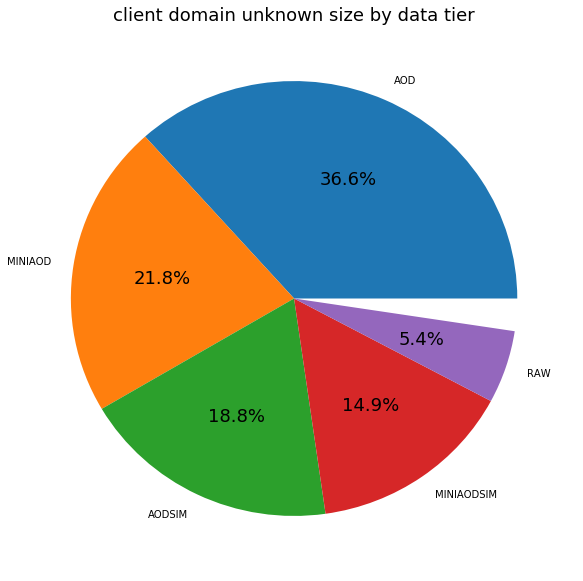

In [11]:
plot_df = pd_reduced[pd_reduced['CLIENT_DOMAIN']=="unknown"].groupby(["DATA_TIER"]).SUM_BYTES_READ.sum().sort_values().nlargest(5)/pd_reduced[pd_reduced['CLIENT_DOMAIN']=="unknown"].SUM_BYTES_READ.sum()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

wedges, texts, autotexts = ax.pie(plot_df.values, labels=plot_df.index, autopct='%1.1f%%', textprops={"fontsize":18})

#print pd_reduced.groupby(["DATA_TIER"]).SUM_BYTES_READ.sum().sort_values()

ax.set_title('client domain unknown size by data tier', fontdict={"fontsize":18})
ax.set_ylabel("", fontdict={"fontsize":18})

#print "CPU equivalent 0:", plot_series[0]/total_hrs
#print "CPU equivalent 1:", plot_series[1]/total_hrs

plt.show()


In [12]:
#print pd_reduced.groupby("DAY").SUM_BYTES_READ.sum()

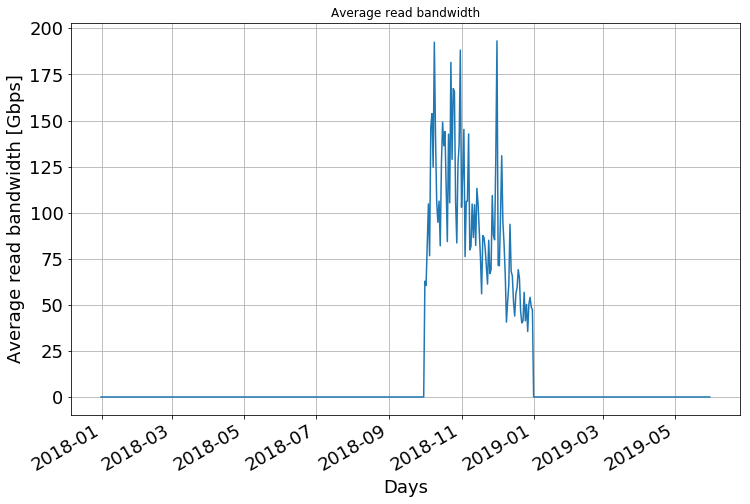

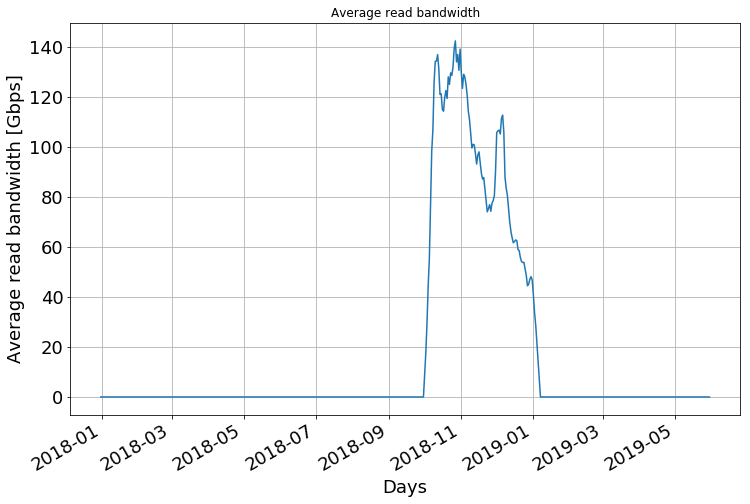

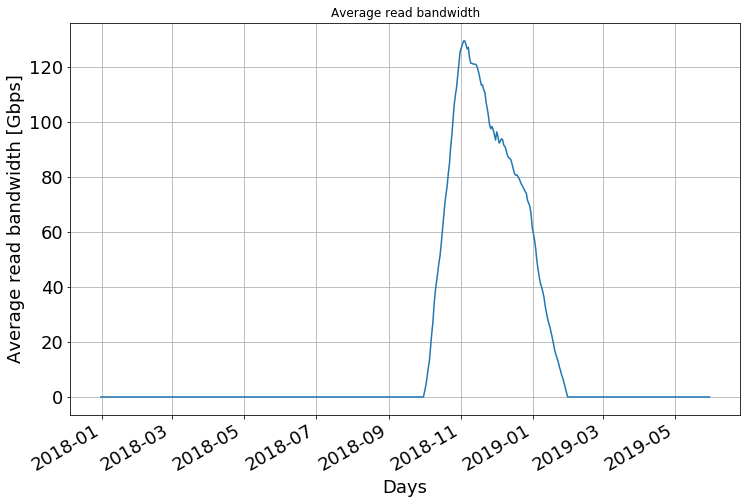

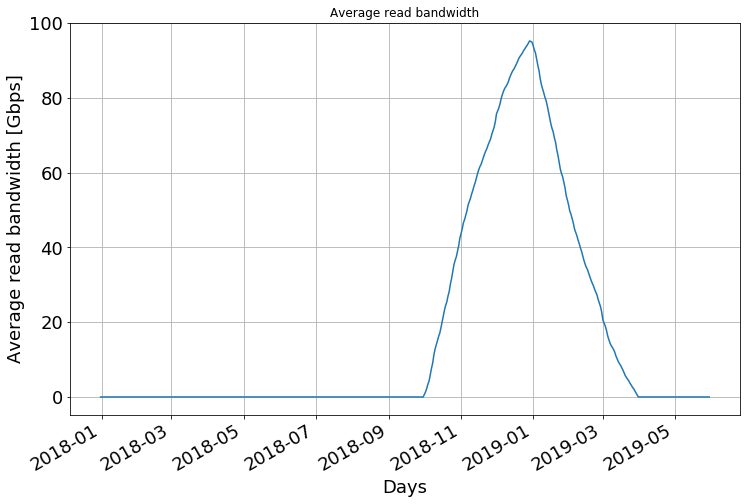

In [45]:

windows = [1,7,30,90]
# 2019
#start_d = datetime.datetime(2019,3,1)
#end_d = datetime.datetime(2019,4,1)
start_date = datetime.datetime(2017,12,31)
end_date = datetime.datetime(2019,5,31)
#total_hrs = (end_date - start_date).days*24


def make_window_ws(df, window_in_day):
    item_sum = []
    date = start_date
    
    item_sum = []
    index = []
    while date < end_date:
        start_interval = date - datetime.timedelta(days=window)
        #print start_interval, date

        tmp_df = df[(df['day'] > start_interval) & (df['day'] <= date)]
                            
        item_sum.append(tmp_df.SUM_BYTES_READ.sum()*8/(window*60*60*24)/1e9 )

        index.append(date)
        
        #print date, df[(df['day'] > start_interval) & (df['day'] <= date)].CRAB_DataBlock.drop_duplicates()
        
        date += datetime.timedelta(days=1)

    #print zip(index, item_sum)

    return pd.Series(data=item_sum, index=index)

for window in windows:
    ax = make_window_ws(pd_reduced, window).plot(title="Average read bandwidth" ,figsize=(12, 8), fontsize=18, x_compat=True)


    #ax.legend(fontsize=18 )
    ax.grid(True)


    ax.tick_params(labelsize=18)

    #ax.set_ylim(0,400000000)

    ax.set_xlabel("Days", fontdict={"fontsize":18})
    ax.set_ylabel("Average read bandwidth [Gbps]", fontdict={"fontsize":18})

    plt.show()


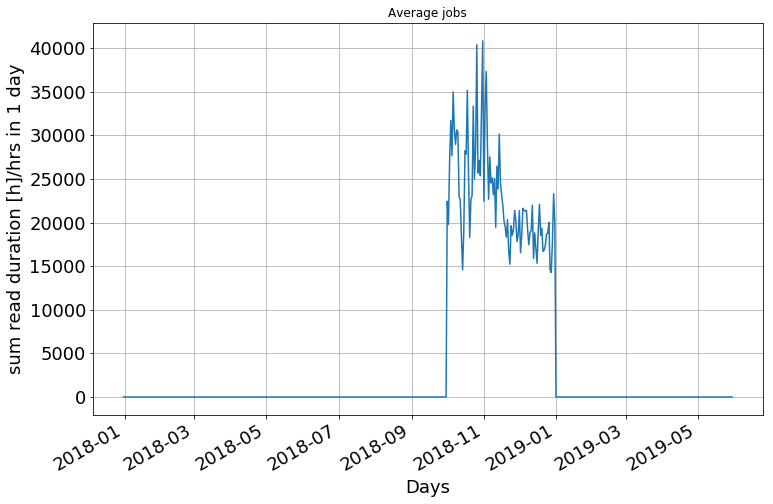

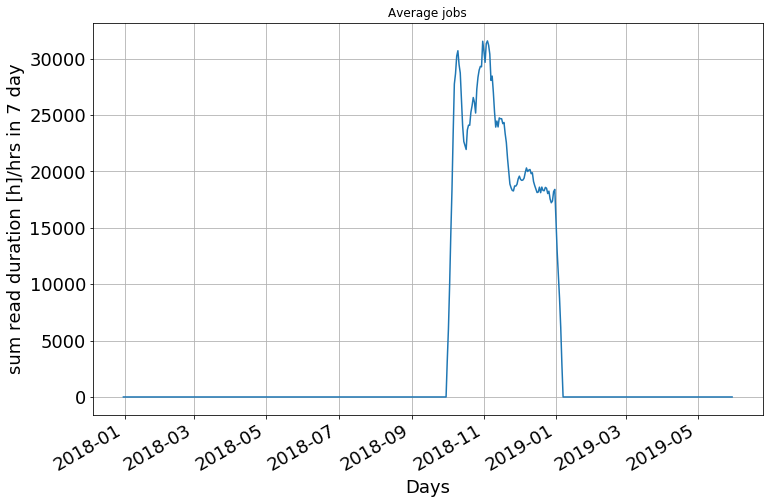

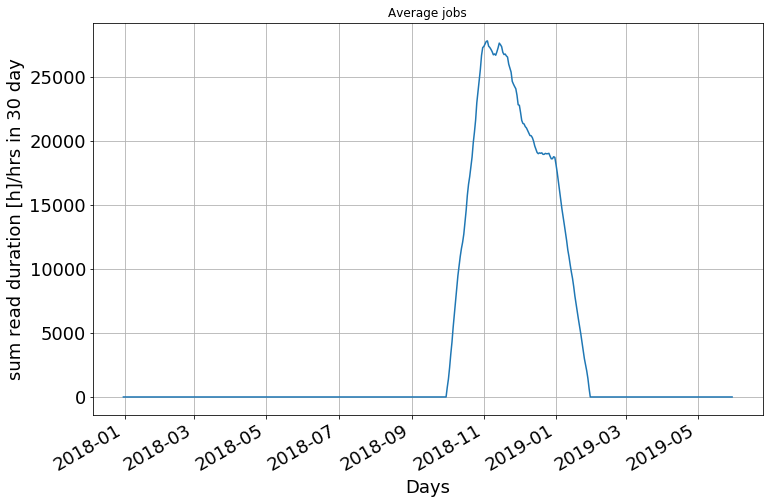

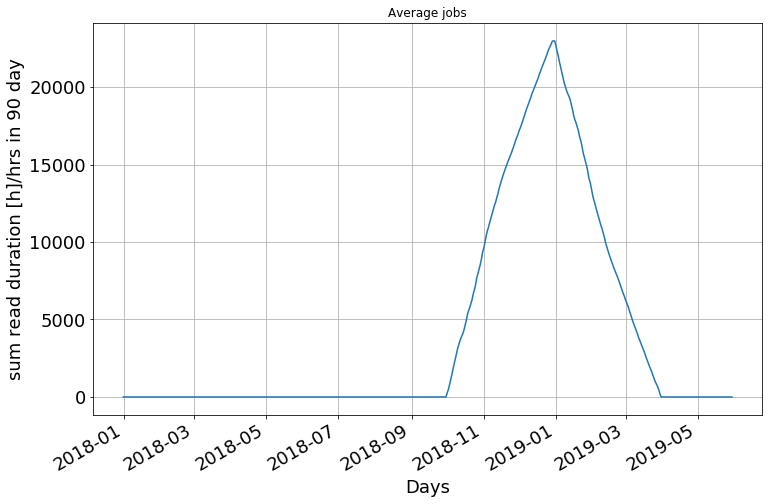

In [46]:
def make_window_ws(df, window_in_day):
    item_sum = []
    date = start_date
    
    item_sum = []
    index = []
    while date < end_date:
        start_interval = date - datetime.timedelta(days=window)
        #print start_interval, date

        tmp_df = df[(df['day'] > start_interval) & (df['day'] <= date)]
                            
        item_sum.append(tmp_df.SUM_DURATION.sum()//(60*60*24*window) )

        index.append(date)
        
        #print date, df[(df['day'] > start_interval) & (df['day'] <= date)].CRAB_DataBlock.drop_duplicates()
        
        date += datetime.timedelta(days=1)

    #print zip(index, item_sum)

    return pd.Series(data=item_sum, index=index)

for window in windows:
    ax = make_window_ws(pd_reduced, window).plot(title="Average jobs" ,figsize=(12, 8), fontsize=18, x_compat=True)


    #ax.legend(fontsize=18 )
    ax.grid(True)


    ax.tick_params(labelsize=18)

    #ax.set_ylim(0,400000000)

    ax.set_xlabel("Days", fontdict={"fontsize":18})
    ax.set_ylabel("sum read duration [h]/hrs in %s day" % window , fontdict={"fontsize":18})

    plt.show()